In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=150 # Number of kernels in convolutional network
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
val_rate=0.2
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
# Reshape the coordinates, in order to apply convolutional operation
x = total_coords.reshape((16*9, 2, 55, 1))

In [22]:
# Input of parameters
# These variables are put into the network after convolution and flattening
x_para = np.hstack((aa, hh, bb))

In [23]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [24]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [25]:
cl_orig = target_df.iloc[:,4].values # Cd values
#target_c4 = target_df.iloc[:,4].values# Cl values

In [26]:
cl = (cl_orig-np.min(cl_orig))/(np.max(cl_orig)-np.min(cl_orig))

In [27]:
y = cl.reshape((-1,1))

In [28]:
y.shape

(144, 1)

In [29]:
x_para_all, x_para_test, x_all, x_test, y_all, y_test = train_test_split(x_para, x, y, test_size=test_rate, random_state=1)

In [30]:
x_para_train, x_para_val, x_train, x_val, y_train, y_val = train_test_split(x_para_all, x_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [31]:
tf.keras.backend.set_image_data_format('channels_last')

In [32]:
input_1 = tf.keras.Input(shape=(2,55,1))
input_2 = tf.keras.Input(shape=(3))

x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1, padding='same',
                                 activation='relu', name='convLayer')(input_1)
x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)

x_flat = tf.keras.layers.Flatten()(x_pool)
x_concat = tf.keras.layers.Concatenate()([x_flat, input_2])

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_concat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# AeroCNN-I
model = tf.keras.Model([input_1, input_2], output_data)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 150)   750         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 150)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 4050)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [35]:
model_directory = "D:\\TrainedModels\\20221205"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [36]:
ckpt_name = model_directory + "20221205steadyValidation_AeroCNN1_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" + str(n_units) +"units_OptimalSettingsCl_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-09, min_lr=1e-06, verbose=1)

In [37]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [38]:
start = datetime.datetime.now()
history = model.fit([x_train, x_para_train], y_train, batch_size=batch_size,
                    validation_data=([x_val, x_para_val], y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/5 [=====>........................] - ETA: 11s - loss: 0.4206 - rmse: 0.6486
Epoch 1: val_loss improved from inf to 0.42010, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 3s 151ms/step - loss: 0.4156 - rmse: 0.6447 - val_loss: 0.4201 - val_rmse: 0.6482 - lr: 1.0000e-04
Epoch 2/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.3845 - rmse: 0.6201
Epoch 2: val_loss improved from 0.42010 to 0.38902, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 38ms/step - loss: 0.3880 - rmse: 0.6229 - val_loss: 0.3890 - val_rmse: 0.6237 - lr: 1.0000e-04
Epoch 3/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.3149 - rmse: 0.5611
Epoch 3: val_loss improved from 0.38902 to 0.34745, saving model to D:\TrainedModels\20

5/5 [==============================] - 0s 36ms/step - loss: 0.0568 - rmse: 0.2383 - val_loss: 0.0515 - val_rmse: 0.2270 - lr: 1.0000e-04
Epoch 23/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0540 - rmse: 0.2324
Epoch 23: val_loss improved from 0.05154 to 0.05058, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 34ms/step - loss: 0.0563 - rmse: 0.2373 - val_loss: 0.0506 - val_rmse: 0.2249 - lr: 1.0000e-04
Epoch 24/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0525 - rmse: 0.2291
Epoch 24: val_loss improved from 0.05058 to 0.05037, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 39ms/step - loss: 0.0553 - rmse: 0.2352 - val_loss: 0.0504 - val_rmse: 0.2244 - lr: 1.0000e-04
Epoch 25/10000
1/5 [=====>.........

1/5 [=====>........................] - ETA: 0s - loss: 0.0105 - rmse: 0.1027
Epoch 63: val_loss improved from 0.00901 to 0.00874, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 37ms/step - loss: 0.0095 - rmse: 0.0976 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 1.0000e-04
Epoch 64/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0100 - rmse: 0.0998
Epoch 64: val_loss improved from 0.00874 to 0.00860, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 36ms/step - loss: 0.0092 - rmse: 0.0961 - val_loss: 0.0086 - val_rmse: 0.0927 - lr: 1.0000e-04
Epoch 65/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0069 - rmse: 0.0828
Epoch 65: val_loss improved from 0.00860 to 0.00831, saving model to D:\TrainedModels\202212052

5/5 [==============================] - 0s 35ms/step - loss: 0.0081 - rmse: 0.0898 - val_loss: 0.0074 - val_rmse: 0.0861 - lr: 1.0000e-04
Epoch 88/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0182 - rmse: 0.1350
Epoch 88: val_loss did not improve from 0.00741
5/5 [==============================] - 0s 14ms/step - loss: 0.0083 - rmse: 0.0910 - val_loss: 0.0079 - val_rmse: 0.0886 - lr: 1.0000e-04
Epoch 89/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0036 - rmse: 0.0600
Epoch 89: val_loss did not improve from 0.00741
5/5 [==============================] - 0s 14ms/step - loss: 0.0082 - rmse: 0.0906 - val_loss: 0.0075 - val_rmse: 0.0868 - lr: 1.0000e-04
Epoch 90/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0058 - rmse: 0.0763
Epoch 90: val_loss did not improve from 0.00741
5/5 [==============================] - 0s 14ms/step - loss: 0.0081 - rmse: 0.0902 - val_loss: 0.0076 - val_rmse: 0.0870 - lr: 1.0000e-04
Epoch 91/10000
1/5 [=====>......

1/5 [=====>........................] - ETA: 0s - loss: 0.0081 - rmse: 0.0899
Epoch 114: val_loss did not improve from 0.00725
5/5 [==============================] - 0s 15ms/step - loss: 0.0080 - rmse: 0.0893 - val_loss: 0.0074 - val_rmse: 0.0860 - lr: 1.0000e-04
Epoch 115/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0053 - rmse: 0.0731
Epoch 115: val_loss did not improve from 0.00725
5/5 [==============================] - 0s 14ms/step - loss: 0.0078 - rmse: 0.0885 - val_loss: 0.0076 - val_rmse: 0.0870 - lr: 1.0000e-04
Epoch 116/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 116: val_loss did not improve from 0.00725
5/5 [==============================] - 0s 14ms/step - loss: 0.0079 - rmse: 0.0890 - val_loss: 0.0075 - val_rmse: 0.0867 - lr: 1.0000e-04
Epoch 117/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0151 - rmse: 0.1231
Epoch 117: val_loss did not improve from 0.00725
5/5 [==============================] 

5/5 [==============================] - 0s 14ms/step - loss: 0.0076 - rmse: 0.0873 - val_loss: 0.0096 - val_rmse: 0.0979 - lr: 1.0000e-04
Epoch 144/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0044 - rmse: 0.0661
Epoch 144: val_loss improved from 0.00725 to 0.00723, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 43ms/step - loss: 0.0080 - rmse: 0.0896 - val_loss: 0.0072 - val_rmse: 0.0850 - lr: 1.0000e-04
Epoch 145/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0132 - rmse: 0.1147
Epoch 145: val_loss did not improve from 0.00723
5/5 [==============================] - 0s 14ms/step - loss: 0.0081 - rmse: 0.0898 - val_loss: 0.0079 - val_rmse: 0.0889 - lr: 1.0000e-04
Epoch 146/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0140 - rmse: 0.1183
Epoch 146: val_loss did not improve from 0.00723
5/5 [=====================

Epoch 170/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0124 - rmse: 0.1113
Epoch 170: val_loss did not improve from 0.00709
5/5 [==============================] - 0s 14ms/step - loss: 0.0077 - rmse: 0.0875 - val_loss: 0.0075 - val_rmse: 0.0866 - lr: 1.0000e-04
Epoch 171/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0112 - rmse: 0.1060
Epoch 171: val_loss did not improve from 0.00709
5/5 [==============================] - 0s 14ms/step - loss: 0.0077 - rmse: 0.0875 - val_loss: 0.0071 - val_rmse: 0.0843 - lr: 1.0000e-04
Epoch 172/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0100 - rmse: 0.0999
Epoch 172: val_loss did not improve from 0.00709
5/5 [==============================] - 0s 14ms/step - loss: 0.0076 - rmse: 0.0871 - val_loss: 0.0076 - val_rmse: 0.0871 - lr: 1.0000e-04
Epoch 173/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0050 - rmse: 0.0707
Epoch 173: val_loss did not improve from 0.00709
5/5 [================

Epoch 199/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0561
Epoch 199: val_loss improved from 0.00704 to 0.00701, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 36ms/step - loss: 0.0072 - rmse: 0.0850 - val_loss: 0.0070 - val_rmse: 0.0837 - lr: 1.0000e-04
Epoch 200/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0055 - rmse: 0.0740
Epoch 200: val_loss did not improve from 0.00701
5/5 [==============================] - 0s 13ms/step - loss: 0.0072 - rmse: 0.0850 - val_loss: 0.0072 - val_rmse: 0.0850 - lr: 1.0000e-04
Epoch 201/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0070 - rmse: 0.0835
Epoch 201: val_loss did not improve from 0.00701
5/5 [==============================] - 0s 14ms/step - loss: 0.0074 - rmse: 0.0861 - val_loss: 0.0072 - val_rmse: 0.0850 - lr: 1.0000e-04
Epoch 202/10000
1/5 [=====

Epoch 225/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0197 - rmse: 0.1404
Epoch 225: val_loss did not improve from 0.00681
5/5 [==============================] - 0s 15ms/step - loss: 0.0069 - rmse: 0.0830 - val_loss: 0.0068 - val_rmse: 0.0826 - lr: 1.0000e-04
Epoch 226/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0491
Epoch 226: val_loss did not improve from 0.00681
5/5 [==============================] - 0s 14ms/step - loss: 0.0072 - rmse: 0.0850 - val_loss: 0.0077 - val_rmse: 0.0875 - lr: 1.0000e-04
Epoch 227/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0076 - rmse: 0.0874
Epoch 227: val_loss improved from 0.00681 to 0.00672, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 33ms/step - loss: 0.0069 - rmse: 0.0828 - val_loss: 0.0067 - val_rmse: 0.0820 - lr: 1.0000e-04
Epoch 228/10000
1/5 [=====

Epoch 252/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0321
Epoch 252: val_loss did not improve from 0.00651
5/5 [==============================] - 0s 14ms/step - loss: 0.0067 - rmse: 0.0818 - val_loss: 0.0068 - val_rmse: 0.0825 - lr: 1.0000e-04
Epoch 253/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0032 - rmse: 0.0567
Epoch 253: val_loss did not improve from 0.00651
5/5 [==============================] - 0s 14ms/step - loss: 0.0073 - rmse: 0.0857 - val_loss: 0.0067 - val_rmse: 0.0819 - lr: 1.0000e-04
Epoch 254/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0044 - rmse: 0.0665
Epoch 254: val_loss did not improve from 0.00651
5/5 [==============================] - 0s 14ms/step - loss: 0.0069 - rmse: 0.0833 - val_loss: 0.0068 - val_rmse: 0.0825 - lr: 1.0000e-04
Epoch 255/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0426
Epoch 255: val_loss did not improve from 0.00651
5/5 [================

Epoch 278/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0064 - rmse: 0.0802
Epoch 278: val_loss did not improve from 0.00615
5/5 [==============================] - 0s 13ms/step - loss: 0.0062 - rmse: 0.0789 - val_loss: 0.0064 - val_rmse: 0.0798 - lr: 1.0000e-04
Epoch 279/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0032 - rmse: 0.0565
Epoch 279: val_loss did not improve from 0.00615
5/5 [==============================] - 0s 14ms/step - loss: 0.0065 - rmse: 0.0807 - val_loss: 0.0063 - val_rmse: 0.0792 - lr: 1.0000e-04
Epoch 280/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 280: val_loss did not improve from 0.00615
5/5 [==============================] - 0s 14ms/step - loss: 0.0062 - rmse: 0.0784 - val_loss: 0.0064 - val_rmse: 0.0799 - lr: 1.0000e-04
Epoch 281/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0027 - rmse: 0.0524
Epoch 281: val_loss did not improve from 0.00615
5/5 [================

5/5 [==============================] - 0s 37ms/step - loss: 0.0058 - rmse: 0.0764 - val_loss: 0.0058 - val_rmse: 0.0763 - lr: 1.0000e-04
Epoch 305/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0104 - rmse: 0.1018
Epoch 305: val_loss did not improve from 0.00582
5/5 [==============================] - 0s 14ms/step - loss: 0.0058 - rmse: 0.0760 - val_loss: 0.0060 - val_rmse: 0.0775 - lr: 1.0000e-04
Epoch 306/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0072 - rmse: 0.0847
Epoch 306: val_loss did not improve from 0.00582
5/5 [==============================] - 0s 14ms/step - loss: 0.0057 - rmse: 0.0757 - val_loss: 0.0059 - val_rmse: 0.0766 - lr: 1.0000e-04
Epoch 307/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0017 - rmse: 0.0416
Epoch 307: val_loss did not improve from 0.00582
5/5 [==============================] - 0s 14ms/step - loss: 0.0057 - rmse: 0.0757 - val_loss: 0.0061 - val_rmse: 0.0778 - lr: 1.0000e-04
Epoch 308/10000
1/5 [=====

5/5 [==============================] - 0s 37ms/step - loss: 0.0052 - rmse: 0.0718 - val_loss: 0.0054 - val_rmse: 0.0732 - lr: 1.0000e-04
Epoch 331/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0045 - rmse: 0.0674
Epoch 331: val_loss did not improve from 0.00536
5/5 [==============================] - 0s 13ms/step - loss: 0.0052 - rmse: 0.0719 - val_loss: 0.0060 - val_rmse: 0.0773 - lr: 1.0000e-04
Epoch 332/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 332: val_loss did not improve from 0.00536
5/5 [==============================] - 0s 14ms/step - loss: 0.0051 - rmse: 0.0716 - val_loss: 0.0055 - val_rmse: 0.0739 - lr: 1.0000e-04
Epoch 333/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0037 - rmse: 0.0611
Epoch 333: val_loss did not improve from 0.00536
5/5 [==============================] - 0s 14ms/step - loss: 0.0051 - rmse: 0.0714 - val_loss: 0.0059 - val_rmse: 0.0770 - lr: 1.0000e-04
Epoch 334/10000
1/5 [=====

5/5 [==============================] - 0s 14ms/step - loss: 0.0046 - rmse: 0.0679 - val_loss: 0.0053 - val_rmse: 0.0731 - lr: 1.0000e-04
Epoch 357/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0560
Epoch 357: val_loss did not improve from 0.00496
5/5 [==============================] - 0s 14ms/step - loss: 0.0047 - rmse: 0.0682 - val_loss: 0.0050 - val_rmse: 0.0710 - lr: 1.0000e-04
Epoch 358/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0045 - rmse: 0.0673
Epoch 358: val_loss improved from 0.00496 to 0.00482, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 35ms/step - loss: 0.0048 - rmse: 0.0691 - val_loss: 0.0048 - val_rmse: 0.0694 - lr: 1.0000e-04
Epoch 359/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0034 - rmse: 0.0583
Epoch 359: val_loss did not improve from 0.00482
5/5 [=====================

5/5 [==============================] - 0s 14ms/step - loss: 0.0045 - rmse: 0.0673 - val_loss: 0.0060 - val_rmse: 0.0775 - lr: 1.0000e-04
Epoch 383/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0058 - rmse: 0.0763
Epoch 383: val_loss did not improve from 0.00437
5/5 [==============================] - 0s 14ms/step - loss: 0.0046 - rmse: 0.0677 - val_loss: 0.0046 - val_rmse: 0.0681 - lr: 1.0000e-04
Epoch 384/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0060 - rmse: 0.0777
Epoch 384: val_loss did not improve from 0.00437
5/5 [==============================] - 0s 14ms/step - loss: 0.0045 - rmse: 0.0670 - val_loss: 0.0045 - val_rmse: 0.0674 - lr: 1.0000e-04
Epoch 385/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0042 - rmse: 0.0649
Epoch 385: val_loss improved from 0.00437 to 0.00424, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [=====================

5/5 [==============================] - 0s 14ms/step - loss: 0.0031 - rmse: 0.0560 - val_loss: 0.0036 - val_rmse: 0.0596 - lr: 1.0000e-04
Epoch 409/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 409: val_loss did not improve from 0.00354
5/5 [==============================] - 0s 14ms/step - loss: 0.0032 - rmse: 0.0568 - val_loss: 0.0042 - val_rmse: 0.0646 - lr: 1.0000e-04
Epoch 410/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 410: val_loss did not improve from 0.00354
5/5 [==============================] - 0s 14ms/step - loss: 0.0033 - rmse: 0.0576 - val_loss: 0.0036 - val_rmse: 0.0600 - lr: 1.0000e-04
Epoch 411/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0458
Epoch 411: val_loss did not improve from 0.00354
5/5 [==============================] - 0s 14ms/step - loss: 0.0030 - rmse: 0.0550 - val_loss: 0.0038 - val_rmse: 0.0619 - lr: 1.0000e-04
Epoch 412/10000
1/5 [=====

5/5 [==============================] - 0s 15ms/step - loss: 0.0029 - rmse: 0.0538 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-04
Epoch 436/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0045 - rmse: 0.0671
Epoch 436: val_loss did not improve from 0.00305
5/5 [==============================] - 0s 15ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-04
Epoch 437/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0362
Epoch 437: val_loss did not improve from 0.00305
5/5 [==============================] - 0s 15ms/step - loss: 0.0030 - rmse: 0.0548 - val_loss: 0.0045 - val_rmse: 0.0673 - lr: 1.0000e-04
Epoch 438/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 438: val_loss did not improve from 0.00305
5/5 [==============================] - 0s 14ms/step - loss: 0.0034 - rmse: 0.0586 - val_loss: 0.0035 - val_rmse: 0.0595 - lr: 1.0000e-04
Epoch 439/10000
1/5 [=====

Epoch 461/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 461: val_loss did not improve from 0.00225
5/5 [==============================] - 0s 14ms/step - loss: 0.0021 - rmse: 0.0458 - val_loss: 0.0025 - val_rmse: 0.0504 - lr: 1.0000e-04
Epoch 462/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0485
Epoch 462: val_loss did not improve from 0.00225
5/5 [==============================] - 0s 14ms/step - loss: 0.0025 - rmse: 0.0501 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-04
Epoch 463/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0041 - rmse: 0.0642
Epoch 463: val_loss did not improve from 0.00225
5/5 [==============================] - 0s 14ms/step - loss: 0.0029 - rmse: 0.0540 - val_loss: 0.0030 - val_rmse: 0.0546 - lr: 1.0000e-04
Epoch 464/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0052 - rmse: 0.0724
Epoch 464: val_loss did not improve from 0.00225
5/5 [================

Epoch 488/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0377
Epoch 488: val_loss improved from 0.00162 to 0.00158, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 46ms/step - loss: 0.0013 - rmse: 0.0361 - val_loss: 0.0016 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 489/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0471
Epoch 489: val_loss improved from 0.00158 to 0.00151, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 45ms/step - loss: 0.0012 - rmse: 0.0346 - val_loss: 0.0015 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 490/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9678e-04 - rmse: 0.0244
Epoch 490: val_loss improved from 0.00151 to 0.00130, saving model to D

Epoch 542/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0360
Epoch 542: val_loss did not improve from 0.00083
5/5 [==============================] - 0s 16ms/step - loss: 0.0012 - rmse: 0.0351 - val_loss: 0.0016 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 543/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0320
Epoch 543: val_loss did not improve from 0.00083
5/5 [==============================] - 0s 16ms/step - loss: 9.7936e-04 - rmse: 0.0313 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 544/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7700e-04 - rmse: 0.0240
Epoch 544: val_loss did not improve from 0.00083
5/5 [==============================] - 0s 15ms/step - loss: 7.6979e-04 - rmse: 0.0277 - val_loss: 0.0011 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 545/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6370e-04 - rmse: 0.0128
Epoch 545: val_loss improved from 0.00083 to 0.00078, 

1/5 [=====>........................] - ETA: 0s - loss: 2.9178e-04 - rmse: 0.0171
Epoch 569: val_loss did not improve from 0.00056
5/5 [==============================] - 0s 14ms/step - loss: 4.2348e-04 - rmse: 0.0206 - val_loss: 5.9977e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 570/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1050e-04 - rmse: 0.0203
Epoch 570: val_loss did not improve from 0.00056
5/5 [==============================] - 0s 14ms/step - loss: 4.3383e-04 - rmse: 0.0208 - val_loss: 6.5004e-04 - val_rmse: 0.0255 - lr: 1.0000e-04
Epoch 571/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7250e-04 - rmse: 0.0165
Epoch 571: val_loss did not improve from 0.00056
5/5 [==============================] - 0s 13ms/step - loss: 3.5921e-04 - rmse: 0.0190 - val_loss: 6.1799e-04 - val_rmse: 0.0249 - lr: 1.0000e-04
Epoch 572/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4853e-05 - rmse: 0.0092
Epoch 572: val_loss did not improve from 0.000

Epoch 623/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.6442e-05 - rmse: 0.0098
Epoch 623: val_loss did not improve from 0.00032
5/5 [==============================] - 0s 14ms/step - loss: 1.4355e-04 - rmse: 0.0120 - val_loss: 3.5777e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 624/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.6307e-05 - rmse: 0.0081
Epoch 624: val_loss did not improve from 0.00032
5/5 [==============================] - 0s 15ms/step - loss: 1.5008e-04 - rmse: 0.0123 - val_loss: 3.8506e-04 - val_rmse: 0.0196 - lr: 1.0000e-04
Epoch 625/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0751e-04 - rmse: 0.0144
Epoch 625: val_loss did not improve from 0.00032
5/5 [==============================] - 0s 14ms/step - loss: 1.3153e-04 - rmse: 0.0115 - val_loss: 3.6747e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 626/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0980e-04 - rmse: 0.0105
Epoch 626: val_loss did not im

5/5 [==============================] - 0s 14ms/step - loss: 5.5681e-04 - rmse: 0.0236 - val_loss: 5.2366e-04 - val_rmse: 0.0229 - lr: 1.0000e-04
Epoch 678/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2040e-04 - rmse: 0.0179
Epoch 678: val_loss did not improve from 0.00026
5/5 [==============================] - 0s 15ms/step - loss: 6.2748e-04 - rmse: 0.0250 - val_loss: 9.7277e-04 - val_rmse: 0.0312 - lr: 1.0000e-04
Epoch 679/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8514e-04 - rmse: 0.0136
Epoch 679: val_loss did not improve from 0.00026
5/5 [==============================] - 0s 14ms/step - loss: 4.0867e-04 - rmse: 0.0202 - val_loss: 3.1876e-04 - val_rmse: 0.0179 - lr: 1.0000e-04
Epoch 680/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9202e-04 - rmse: 0.0139
Epoch 680: val_loss did not improve from 0.00026
5/5 [==============================] - 0s 15ms/step - loss: 2.7874e-04 - rmse: 0.0167 - val_loss: 4.3597e-04 - val_rmse: 0.0209

1/5 [=====>........................] - ETA: 0s - loss: 1.1878e-04 - rmse: 0.0109
Epoch 731: val_loss did not improve from 0.00020
5/5 [==============================] - 0s 14ms/step - loss: 9.2643e-05 - rmse: 0.0096 - val_loss: 1.9977e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 732/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7919e-05 - rmse: 0.0069
Epoch 732: val_loss did not improve from 0.00020
5/5 [==============================] - 0s 14ms/step - loss: 7.1674e-05 - rmse: 0.0085 - val_loss: 2.2088e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 733/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4944e-05 - rmse: 0.0067
Epoch 733: val_loss did not improve from 0.00020
5/5 [==============================] - 0s 14ms/step - loss: 4.4013e-05 - rmse: 0.0066 - val_loss: 2.1067e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 734/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.1959e-05 - rmse: 0.0091
Epoch 734: val_loss did not improve from 0.000

Epoch 785/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0173e-05 - rmse: 0.0045
Epoch 785: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 14ms/step - loss: 3.3413e-05 - rmse: 0.0058 - val_loss: 1.8437e-04 - val_rmse: 0.0136 - lr: 1.0000e-04
Epoch 786/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8584e-05 - rmse: 0.0053
Epoch 786: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 14ms/step - loss: 2.8067e-05 - rmse: 0.0053 - val_loss: 2.0894e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 787/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4685e-05 - rmse: 0.0059
Epoch 787: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 14ms/step - loss: 4.5529e-05 - rmse: 0.0067 - val_loss: 1.6952e-04 - val_rmse: 0.0130 - lr: 1.0000e-04
Epoch 788/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9241e-05 - rmse: 0.0044
Epoch 788: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 8.1471e-04 - rmse: 0.0285
Epoch 841: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 14ms/step - loss: 5.5267e-04 - rmse: 0.0235 - val_loss: 5.3361e-04 - val_rmse: 0.0231 - lr: 1.0000e-04
Epoch 842/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1892e-04 - rmse: 0.0109
Epoch 842: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 13ms/step - loss: 6.3881e-04 - rmse: 0.0253 - val_loss: 0.0012 - val_rmse: 0.0348 - lr: 1.0000e-04
Epoch 843/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0335
Epoch 843: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 14ms/step - loss: 7.4214e-04 - rmse: 0.0272 - val_loss: 0.0013 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 844/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0365
Epoch 844: val_loss did not improve from 0.00014
5/5 [========

Epoch 869/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8709e-05 - rmse: 0.0070
Epoch 869: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 4.4652e-05 - rmse: 0.0067 - val_loss: 1.8547e-04 - val_rmse: 0.0136 - lr: 1.0000e-04
Epoch 870/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7920e-05 - rmse: 0.0062
Epoch 870: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 3.3016e-05 - rmse: 0.0057 - val_loss: 1.4667e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 871/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9186e-05 - rmse: 0.0063
Epoch 871: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 5.0971e-05 - rmse: 0.0071 - val_loss: 1.3798e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 872/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4281e-05 - rmse: 0.0059
Epoch 872: val_loss did not im

Epoch 897/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5558e-06 - rmse: 0.0021
Epoch 897: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 1.8004e-05 - rmse: 0.0042 - val_loss: 1.6849e-04 - val_rmse: 0.0130 - lr: 1.0000e-04
Epoch 898/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2122e-05 - rmse: 0.0035
Epoch 898: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.3229e-05 - rmse: 0.0048 - val_loss: 1.3506e-04 - val_rmse: 0.0116 - lr: 1.0000e-04
Epoch 899/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3859e-05 - rmse: 0.0037
Epoch 899: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.5023e-05 - rmse: 0.0039 - val_loss: 1.4344e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 900/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1414e-05 - rmse: 0.0034
Epoch 900: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 1.4072e-04 - rmse: 0.0119
Epoch 953: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 5.3248e-04 - rmse: 0.0231 - val_loss: 5.9051e-04 - val_rmse: 0.0243 - lr: 1.0000e-04
Epoch 954/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4202e-05 - rmse: 0.0058
Epoch 954: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.2561e-04 - rmse: 0.0150 - val_loss: 5.2807e-04 - val_rmse: 0.0230 - lr: 1.0000e-04
Epoch 955/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.6327e-04 - rmse: 0.0276
Epoch 955: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.5334e-04 - rmse: 0.0159 - val_loss: 6.9523e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 956/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0365
Epoch 956: val_loss did not improve from 0.00012
5

5/5 [==============================] - 0s 14ms/step - loss: 2.9668e-04 - rmse: 0.0172 - val_loss: 4.5310e-04 - val_rmse: 0.0213 - lr: 1.0000e-04
Epoch 1010/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0170e-04 - rmse: 0.0101
Epoch 1010: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.8828e-04 - rmse: 0.0137 - val_loss: 4.0325e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 1011/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5418e-04 - rmse: 0.0124
Epoch 1011: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.2421e-04 - rmse: 0.0111 - val_loss: 4.6350e-04 - val_rmse: 0.0215 - lr: 1.0000e-04
Epoch 1012/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.4926e-05 - rmse: 0.0097
Epoch 1012: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.2562e-04 - rmse: 0.0112 - val_loss: 3.0093e-04 - val_rmse: 

5/5 [==============================] - 0s 14ms/step - loss: 2.8514e-05 - rmse: 0.0053 - val_loss: 2.1766e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 1038/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3863e-05 - rmse: 0.0037
Epoch 1038: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 3.3333e-05 - rmse: 0.0058 - val_loss: 1.4757e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1039/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3270e-05 - rmse: 0.0036
Epoch 1039: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.8176e-05 - rmse: 0.0053 - val_loss: 1.8093e-04 - val_rmse: 0.0135 - lr: 1.0000e-04
Epoch 1040/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6719e-05 - rmse: 0.0075
Epoch 1040: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 3.5747e-05 - rmse: 0.0060 - val_loss: 1.3608e-04 - val_rmse: 

5/5 [==============================] - 0s 14ms/step - loss: 1.5624e-05 - rmse: 0.0040 - val_loss: 1.4871e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 1066/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.8384e-06 - rmse: 0.0031
Epoch 1066: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.3044e-05 - rmse: 0.0036 - val_loss: 1.4625e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1067/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6652e-06 - rmse: 0.0029
Epoch 1067: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.2354e-05 - rmse: 0.0035 - val_loss: 1.7876e-04 - val_rmse: 0.0134 - lr: 1.0000e-04
Epoch 1068/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6261e-05 - rmse: 0.0051
Epoch 1068: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.9365e-05 - rmse: 0.0044 - val_loss: 1.4460e-04 - val_rmse: 

1/5 [=====>........................] - ETA: 0s - loss: 7.5080e-06 - rmse: 0.0027
Epoch 1121: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 6.1482e-06 - rmse: 0.0025 - val_loss: 1.4343e-04 - val_rmse: 0.0120 - lr: 5.0000e-05
Epoch 1122/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.7309e-06 - rmse: 0.0028
Epoch 1122: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 5.6452e-06 - rmse: 0.0024 - val_loss: 1.3681e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 1123/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8352e-06 - rmse: 0.0022
Epoch 1123: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 6.1776e-06 - rmse: 0.0025 - val_loss: 1.3863e-04 - val_rmse: 0.0118 - lr: 5.0000e-05
Epoch 1124/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9178e-06 - rmse: 0.0020
Epoch 1124: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 9.9101e-06 - rmse: 0.0031
Epoch 1149: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 9.3732e-06 - rmse: 0.0031 - val_loss: 1.4133e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 1150/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1695e-06 - rmse: 0.0018
Epoch 1150: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 15ms/step - loss: 7.3136e-06 - rmse: 0.0027 - val_loss: 1.3649e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 1151/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6312e-06 - rmse: 0.0019
Epoch 1151: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 7.1174e-06 - rmse: 0.0027 - val_loss: 1.3689e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 1152/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9886e-06 - rmse: 0.0020
Epoch 1152: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 3.0613e-06 - rmse: 0.0017
Epoch 1177: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 5.4127e-06 - rmse: 0.0023 - val_loss: 1.3359e-04 - val_rmse: 0.0116 - lr: 5.0000e-05
Epoch 1178/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1962e-06 - rmse: 0.0020
Epoch 1178: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 7.0102e-06 - rmse: 0.0026 - val_loss: 1.3490e-04 - val_rmse: 0.0116 - lr: 5.0000e-05
Epoch 1179/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6816e-06 - rmse: 0.0016
Epoch 1179: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 7.4835e-06 - rmse: 0.0027 - val_loss: 1.3734e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 1180/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.2405e-06 - rmse: 0.0023
Epoch 1180: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 3.7376e-06 - rmse: 0.0019
Epoch 1205: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 5.2665e-06 - rmse: 0.0023 - val_loss: 1.4169e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 1206/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.5777e-06 - rmse: 0.0028
Epoch 1206: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 5.5494e-06 - rmse: 0.0024 - val_loss: 1.3646e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 1207/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6884e-06 - rmse: 0.0019
Epoch 1207: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 4.5488e-06 - rmse: 0.0021 - val_loss: 1.3825e-04 - val_rmse: 0.0118 - lr: 5.0000e-05
Epoch 1208/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.9166e-06 - rmse: 0.0030
Epoch 1208: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 2.4610e-06 - rmse: 0.0016
Epoch 1233: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 5.7444e-06 - rmse: 0.0024 - val_loss: 1.3570e-04 - val_rmse: 0.0116 - lr: 5.0000e-05
Epoch 1234/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7210e-06 - rmse: 0.0022
Epoch 1234: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 6.1204e-06 - rmse: 0.0025 - val_loss: 1.4203e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 1235/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4309e-06 - rmse: 0.0021
Epoch 1235: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 5.4305e-06 - rmse: 0.0023 - val_loss: 1.4491e-04 - val_rmse: 0.0120 - lr: 5.0000e-05
Epoch 1236/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5258e-06 - rmse: 0.0026
Epoch 1236: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 4.5188e-06 - rmse: 0.0021
Epoch 1261: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 5.3195e-06 - rmse: 0.0023 - val_loss: 1.3638e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 1262/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9043e-06 - rmse: 0.0024
Epoch 1262: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 15ms/step - loss: 5.5373e-06 - rmse: 0.0024 - val_loss: 1.3637e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 1263/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8959e-06 - rmse: 0.0022
Epoch 1263: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 15ms/step - loss: 6.8572e-06 - rmse: 0.0026 - val_loss: 1.5015e-04 - val_rmse: 0.0123 - lr: 5.0000e-05
Epoch 1264/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.1836e-06 - rmse: 0.0023
Epoch 1264: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 1.2736e-05 - rmse: 0.0036
Epoch 1289: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 1.3084e-05 - rmse: 0.0036 - val_loss: 1.5612e-04 - val_rmse: 0.0125 - lr: 5.0000e-05
Epoch 1290/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9339e-05 - rmse: 0.0044
Epoch 1290: val_loss did not improve from 0.00012

Epoch 1290: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
5/5 [==============================] - 0s 14ms/step - loss: 1.4848e-05 - rmse: 0.0039 - val_loss: 1.7880e-04 - val_rmse: 0.0134 - lr: 5.0000e-05
Epoch 1291/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3022e-05 - rmse: 0.0048
Epoch 1291: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 1.4691e-05 - rmse: 0.0038 - val_loss: 1.4168e-04 - val_rmse: 0.0119 - lr: 2.5000e-05
Epoch 1292/10000
1/5 [=====>........................] - ET

Epoch 1317/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8818e-06 - rmse: 0.0017
Epoch 1317: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 4.6288e-06 - rmse: 0.0022 - val_loss: 1.3959e-04 - val_rmse: 0.0118 - lr: 2.5000e-05
Epoch 1318/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6284e-06 - rmse: 0.0022
Epoch 1318: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 4.9222e-06 - rmse: 0.0022 - val_loss: 1.4741e-04 - val_rmse: 0.0121 - lr: 2.5000e-05
Epoch 1319/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1344e-06 - rmse: 0.0020
Epoch 1319: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 3.9410e-06 - rmse: 0.0020 - val_loss: 1.4430e-04 - val_rmse: 0.0120 - lr: 2.5000e-05
Epoch 1320/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0835e-06 - rmse: 0.0018
Epoch 1320: val_loss di

Epoch 1345/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6794e-06 - rmse: 0.0022
Epoch 1345: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 3.3372e-06 - rmse: 0.0018 - val_loss: 1.4507e-04 - val_rmse: 0.0120 - lr: 2.5000e-05
Epoch 1346/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4646e-06 - rmse: 0.0016
Epoch 1346: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 3.6532e-06 - rmse: 0.0019 - val_loss: 1.3991e-04 - val_rmse: 0.0118 - lr: 2.5000e-05
Epoch 1347/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3359e-06 - rmse: 0.0021
Epoch 1347: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 3.5189e-06 - rmse: 0.0019 - val_loss: 1.4528e-04 - val_rmse: 0.0121 - lr: 2.5000e-05
Epoch 1348/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2555e-06 - rmse: 0.0015
Epoch 1348: val_loss di

Epoch 1373/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6490e-06 - rmse: 0.0013
Epoch 1373: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 3.0729e-06 - rmse: 0.0018 - val_loss: 1.3825e-04 - val_rmse: 0.0118 - lr: 2.5000e-05
Epoch 1374/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5917e-06 - rmse: 0.0021
Epoch 1374: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.9704e-06 - rmse: 0.0017 - val_loss: 1.4263e-04 - val_rmse: 0.0119 - lr: 2.5000e-05
Epoch 1375/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4020e-06 - rmse: 0.0015
Epoch 1375: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 3.3730e-06 - rmse: 0.0018 - val_loss: 1.4042e-04 - val_rmse: 0.0118 - lr: 2.5000e-05
Epoch 1376/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8421e-06 - rmse: 0.0017
Epoch 1376: val_loss di

Epoch 1401/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0514e-06 - rmse: 0.0017
Epoch 1401: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 2.8197e-06 - rmse: 0.0017 - val_loss: 1.4052e-04 - val_rmse: 0.0119 - lr: 2.5000e-05
Epoch 1402/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1773e-06 - rmse: 0.0015
Epoch 1402: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.7415e-06 - rmse: 0.0017 - val_loss: 1.4068e-04 - val_rmse: 0.0119 - lr: 2.5000e-05
Epoch 1403/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0433e-06 - rmse: 0.0020
Epoch 1403: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.8516e-06 - rmse: 0.0017 - val_loss: 1.4413e-04 - val_rmse: 0.0120 - lr: 2.5000e-05
Epoch 1404/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6992e-06 - rmse: 0.0019
Epoch 1404: val_loss di

Epoch 1429/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6382e-06 - rmse: 0.0013
Epoch 1429: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 2.9633e-06 - rmse: 0.0017 - val_loss: 1.3879e-04 - val_rmse: 0.0118 - lr: 2.5000e-05
Epoch 1430/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4422e-06 - rmse: 0.0016
Epoch 1430: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.8359e-06 - rmse: 0.0017 - val_loss: 1.3630e-04 - val_rmse: 0.0117 - lr: 2.5000e-05
Epoch 1431/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8482e-06 - rmse: 0.0014
Epoch 1431: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 2.8602e-06 - rmse: 0.0017 - val_loss: 1.4123e-04 - val_rmse: 0.0119 - lr: 2.5000e-05
Epoch 1432/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8170e-06 - rmse: 0.0013
Epoch 1432: val_loss di

Epoch 1457/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9022e-06 - rmse: 0.0014
Epoch 1457: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 2.6171e-06 - rmse: 0.0016 - val_loss: 1.3669e-04 - val_rmse: 0.0117 - lr: 2.5000e-05
Epoch 1458/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7549e-06 - rmse: 0.0017
Epoch 1458: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.6379e-06 - rmse: 0.0016 - val_loss: 1.3765e-04 - val_rmse: 0.0117 - lr: 2.5000e-05
Epoch 1459/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3918e-06 - rmse: 0.0012
Epoch 1459: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.3910e-06 - rmse: 0.0015 - val_loss: 1.4257e-04 - val_rmse: 0.0119 - lr: 2.5000e-05
Epoch 1460/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7546e-06 - rmse: 0.0019
Epoch 1460: val_loss di

Epoch 1485/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8792e-06 - rmse: 0.0017
Epoch 1485: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 3.0031e-06 - rmse: 0.0017 - val_loss: 1.3413e-04 - val_rmse: 0.0116 - lr: 2.5000e-05
Epoch 1486/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9367e-06 - rmse: 0.0014
Epoch 1486: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 2.4621e-06 - rmse: 0.0016 - val_loss: 1.4333e-04 - val_rmse: 0.0120 - lr: 2.5000e-05
Epoch 1487/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5842e-06 - rmse: 0.0013
Epoch 1487: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 2.4300e-06 - rmse: 0.0016 - val_loss: 1.4038e-04 - val_rmse: 0.0118 - lr: 2.5000e-05
Epoch 1488/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.5108e-07 - rmse: 9.7523e-04
Epoch 1488: val_los

Epoch 1513/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6861e-06 - rmse: 0.0013
Epoch 1513: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.1503e-06 - rmse: 0.0015 - val_loss: 1.3739e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 1514/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1315e-06 - rmse: 0.0015
Epoch 1514: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 2.1049e-06 - rmse: 0.0015 - val_loss: 1.3677e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 1515/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3984e-06 - rmse: 0.0015
Epoch 1515: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 2.0785e-06 - rmse: 0.0014 - val_loss: 1.3969e-04 - val_rmse: 0.0118 - lr: 1.2500e-05
Epoch 1516/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9242e-06 - rmse: 0.0014
Epoch 1516: val_loss di

Epoch 1541/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3464e-06 - rmse: 0.0012
Epoch 1541: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.9462e-06 - rmse: 0.0014 - val_loss: 1.3935e-04 - val_rmse: 0.0118 - lr: 1.2500e-05
Epoch 1542/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0485e-06 - rmse: 0.0017
Epoch 1542: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 2.0384e-06 - rmse: 0.0014 - val_loss: 1.3837e-04 - val_rmse: 0.0118 - lr: 1.2500e-05
Epoch 1543/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0861e-06 - rmse: 0.0014
Epoch 1543: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.0871e-06 - rmse: 0.0014 - val_loss: 1.3718e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 1544/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6413e-06 - rmse: 0.0016
Epoch 1544: val_loss di

Epoch 1569/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7946e-06 - rmse: 0.0013
Epoch 1569: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.2184e-06 - rmse: 0.0015 - val_loss: 1.3503e-04 - val_rmse: 0.0116 - lr: 1.2500e-05
Epoch 1570/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9464e-06 - rmse: 0.0017
Epoch 1570: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.6160e-06 - rmse: 0.0016 - val_loss: 1.3954e-04 - val_rmse: 0.0118 - lr: 1.2500e-05
Epoch 1571/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4564e-06 - rmse: 0.0019
Epoch 1571: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.8337e-06 - rmse: 0.0017 - val_loss: 1.3361e-04 - val_rmse: 0.0116 - lr: 1.2500e-05
Epoch 1572/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8814e-06 - rmse: 0.0017
Epoch 1572: val_loss di

Epoch 1597/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3204e-06 - rmse: 0.0011
Epoch 1597: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.8164e-06 - rmse: 0.0013 - val_loss: 1.3862e-04 - val_rmse: 0.0118 - lr: 1.2500e-05
Epoch 1598/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5730e-07 - rmse: 8.1074e-04
Epoch 1598: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.0019e-06 - rmse: 0.0014 - val_loss: 1.3725e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 1599/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4448e-06 - rmse: 0.0016
Epoch 1599: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.8551e-06 - rmse: 0.0014 - val_loss: 1.3836e-04 - val_rmse: 0.0118 - lr: 1.2500e-05
Epoch 1600/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.5228e-07 - rmse: 9.7585e-04
Epoch 1600: val

Epoch 1625/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8130e-06 - rmse: 0.0013
Epoch 1625: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.8583e-06 - rmse: 0.0014 - val_loss: 1.3433e-04 - val_rmse: 0.0116 - lr: 1.2500e-05
Epoch 1626/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0610e-06 - rmse: 0.0014
Epoch 1626: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.9602e-06 - rmse: 0.0014 - val_loss: 1.3605e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 1627/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2377e-06 - rmse: 0.0015
Epoch 1627: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 2.0774e-06 - rmse: 0.0014 - val_loss: 1.3584e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 1628/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3025e-06 - rmse: 0.0015
Epoch 1628: val_loss di

Epoch 1653/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7856e-06 - rmse: 0.0017
Epoch 1653: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 2.1069e-06 - rmse: 0.0015 - val_loss: 1.3620e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 1654/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3908e-06 - rmse: 0.0012
Epoch 1654: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.8811e-06 - rmse: 0.0014 - val_loss: 1.3597e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 1655/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6335e-06 - rmse: 0.0016
Epoch 1655: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.8283e-06 - rmse: 0.0014 - val_loss: 1.3812e-04 - val_rmse: 0.0118 - lr: 1.2500e-05
Epoch 1656/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0234e-06 - rmse: 0.0017
Epoch 1656: val_loss di

Epoch 1681/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0791e-06 - rmse: 0.0014
Epoch 1681: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.6922e-06 - rmse: 0.0013 - val_loss: 1.3379e-04 - val_rmse: 0.0116 - lr: 1.2500e-05
Epoch 1682/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5314e-06 - rmse: 0.0012
Epoch 1682: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.7361e-06 - rmse: 0.0013 - val_loss: 1.3474e-04 - val_rmse: 0.0116 - lr: 1.2500e-05
Epoch 1683/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0815e-06 - rmse: 0.0014
Epoch 1683: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.6485e-06 - rmse: 0.0013 - val_loss: 1.3774e-04 - val_rmse: 0.0117 - lr: 1.2500e-05
Epoch 1684/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5036e-06 - rmse: 0.0012
Epoch 1684: val_loss di

Epoch 1709/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6237e-06 - rmse: 0.0016
Epoch 1709: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.5712e-06 - rmse: 0.0013 - val_loss: 1.3627e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 1710/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4387e-06 - rmse: 0.0012
Epoch 1710: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.6299e-06 - rmse: 0.0013 - val_loss: 1.3466e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1711/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.9683e-07 - rmse: 8.9265e-04
Epoch 1711: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 1.7111e-06 - rmse: 0.0013 - val_loss: 1.3718e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 1712/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9697e-06 - rmse: 0.0014
Epoch 1712: val_los

Epoch 1737/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2003e-06 - rmse: 0.0011
Epoch 1737: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.5227e-06 - rmse: 0.0012 - val_loss: 1.3499e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1738/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0440e-06 - rmse: 0.0010
Epoch 1738: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.5662e-06 - rmse: 0.0013 - val_loss: 1.3555e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1739/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7201e-06 - rmse: 0.0013
Epoch 1739: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.5075e-06 - rmse: 0.0012 - val_loss: 1.3534e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1740/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3712e-06 - rmse: 0.0012
Epoch 1740: val_loss di

Epoch 1765/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4594e-06 - rmse: 0.0012
Epoch 1765: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.5281e-06 - rmse: 0.0012 - val_loss: 1.3561e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1766/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1591e-06 - rmse: 0.0011
Epoch 1766: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.4865e-06 - rmse: 0.0012 - val_loss: 1.3499e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1767/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7619e-06 - rmse: 0.0013
Epoch 1767: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.5406e-06 - rmse: 0.0012 - val_loss: 1.3552e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1768/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.4170e-07 - rmse: 9.7041e-04
Epoch 1768: val_los

Epoch 1793/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.7419e-07 - rmse: 8.7988e-04
Epoch 1793: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 15ms/step - loss: 1.4477e-06 - rmse: 0.0012 - val_loss: 1.3471e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1794/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5346e-06 - rmse: 0.0012
Epoch 1794: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.4781e-06 - rmse: 0.0012 - val_loss: 1.3555e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1795/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9442e-06 - rmse: 0.0014
Epoch 1795: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 1.5557e-06 - rmse: 0.0012 - val_loss: 1.3537e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1796/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2533e-06 - rmse: 0.0011
Epoch 1796: val_los

Epoch 1821/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.0237e-07 - rmse: 8.9575e-04
Epoch 1821: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.5300e-06 - rmse: 0.0012 - val_loss: 1.3536e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1822/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2456e-06 - rmse: 0.0011
Epoch 1822: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 15ms/step - loss: 1.5419e-06 - rmse: 0.0012 - val_loss: 1.3346e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1823/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2470e-06 - rmse: 0.0011
Epoch 1823: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 15ms/step - loss: 1.5197e-06 - rmse: 0.0012 - val_loss: 1.3531e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1824/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2259e-06 - rmse: 0.0011
Epoch 1824: val_los

Epoch 1849/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7722e-06 - rmse: 0.0013
Epoch 1849: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 15ms/step - loss: 1.4935e-06 - rmse: 0.0012 - val_loss: 1.3548e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1850/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6858e-06 - rmse: 0.0013
Epoch 1850: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 15ms/step - loss: 1.5115e-06 - rmse: 0.0012 - val_loss: 1.3378e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1851/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2677e-06 - rmse: 0.0011
Epoch 1851: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.3889e-06 - rmse: 0.0012 - val_loss: 1.3517e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1852/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3674e-07 - rmse: 9.6785e-04
Epoch 1852: val_los

Epoch 1877/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.1689e-07 - rmse: 7.1895e-04
Epoch 1877: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.6979e-06 - rmse: 0.0013 - val_loss: 1.3404e-04 - val_rmse: 0.0116 - lr: 6.2500e-06
Epoch 1878/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8453e-06 - rmse: 0.0014
Epoch 1878: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.8303e-06 - rmse: 0.0014 - val_loss: 1.3738e-04 - val_rmse: 0.0117 - lr: 6.2500e-06
Epoch 1879/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0711e-06 - rmse: 0.0014
Epoch 1879: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 14ms/step - loss: 1.7759e-06 - rmse: 0.0013 - val_loss: 1.3334e-04 - val_rmse: 0.0115 - lr: 6.2500e-06
Epoch 1880/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2569e-06 - rmse: 0.0011
Epoch 1880: val_los

In [39]:
time = end - start
print("Training time:", time)

Training time: 0:02:25.792228


In [40]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221205eroCNN1_optimalSettings\\test"+str(test_rate)+'_'+str(n_kernels)+"kernels_Clonly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

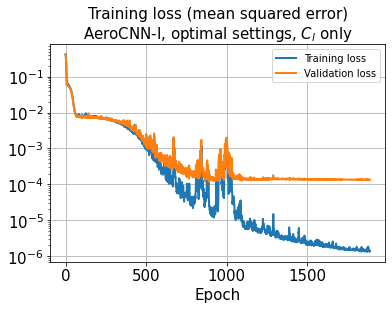

In [41]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

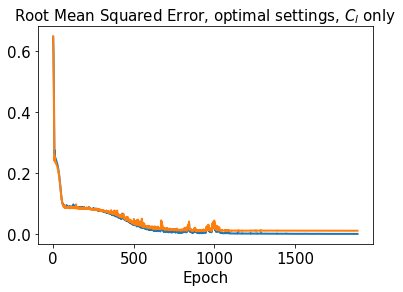

In [42]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

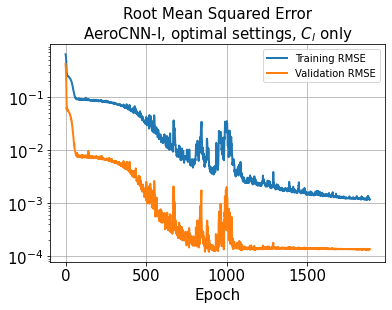

In [43]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [44]:
train_results = model.evaluate([x_train, x_para_train], y_train)

4/4 [==============================] - 0s 16ms/step - loss: 3.3584e-05 - rmse: 0.0058


In [45]:
test_results = model.evaluate([x_test, x_para_test], y_test)

1/1 [==============================] - 0s 70ms/step - loss: 7.4793e-05 - rmse: 0.0086


In [46]:
decoded_train_ = model.predict([x_train, x_para_train])
decoded_val_ = model.predict([x_val, x_para_val])
decoded_test_ = model.predict([x_test, x_para_test])

1/1 [==============================] - 0s 16ms/step


In [47]:
index_train = np.unique(np.where(np.isin(cl, y_train)))
index_val = np.unique(np.where(np.isin(cl, y_val)))
index_test = np.unique(np.where(np.isin(cl, y_test)))

In [48]:
y_train = y_train*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
y_val = y_val*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
y_test = y_test*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)

In [49]:
decoded_train = decoded_train_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
decoded_val = decoded_val_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
decoded_test = decoded_test_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)

In [50]:
model_directory = "D:\\TrainedModels\\20221205"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221205steadyValidation_AeroCNN1_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels) +"kernels_optimalSettings_Clonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = np.abs(decoded_train - y_train)

In [52]:
error_val_abs = np.abs(decoded_val - y_val)

In [53]:
error_test_abs = np.abs(decoded_test - y_test)

In [54]:
os.chdir(storage_dir)

In [55]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.008855481460074172


In [56]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.0168146152983429


In [57]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.012936874841293786


In [58]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [59]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum((y_val[i]+1e-07)**2))
    l2_error_val_list.append(l2_error_val_data)

In [60]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

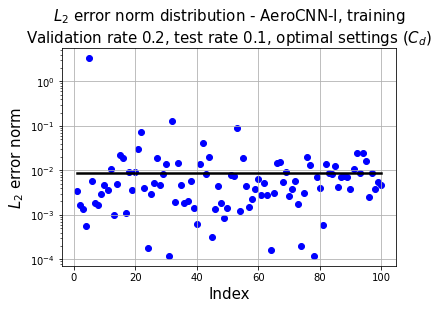

In [61]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

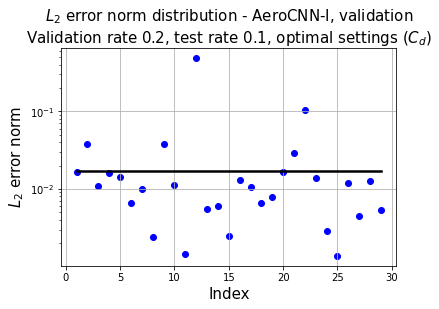

In [62]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, validation\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

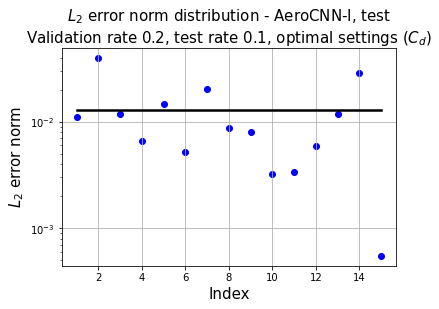

In [63]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict([x, x_para])

5/5 [==============================] - 0s 15ms/step


In [65]:
def CL_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest):
    
    #title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl
    
    #title_n_Cd = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_D$ prediction, L2 error=%.4f'%(l2_error_Cd)
    title_n_Cl = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_L$ prediction, L2 error=%.4f'%(l2_error_Cl)
    
    if i==0:
#         title_Cd, title_Cl = title_0_Cd, title_0_Cl
#         savename1,savename2 = "CdComparison_NACA0018.jpg", "ClComparison_NACA0018.jpg"
        title_Cl = title_0_Cl
        savename2 = "ClComparison_NACA0018.jpg"
    else:
#         title_Cd, title_Cl = title_n_Cd, title_n_Cl
        title_Cl = title_n_Cl
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    '''# CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='b', label='Training set')
    plt.scatter(aVal, iVal*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='g', label='Validation set')
    plt.scatter(aTest, iTest*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()'''

   # CL graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

1/1 [==============================] - 0s 59ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cl: 0.0246


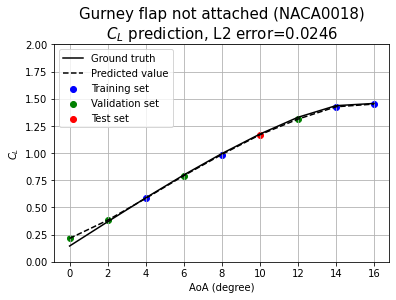

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0035


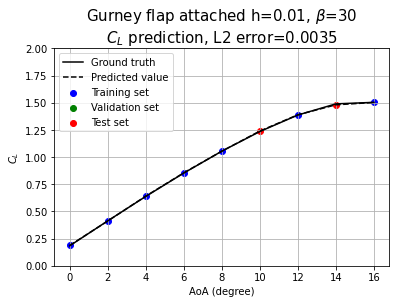

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0047


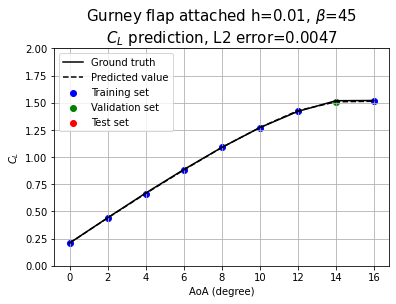

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0057


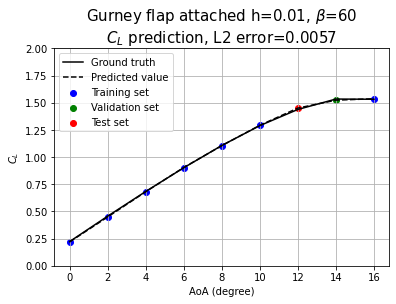

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0128


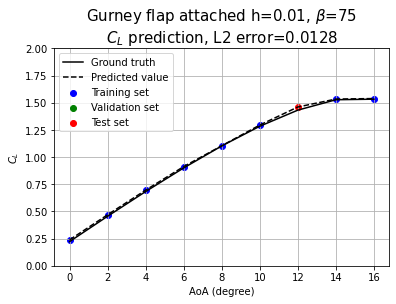

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0082


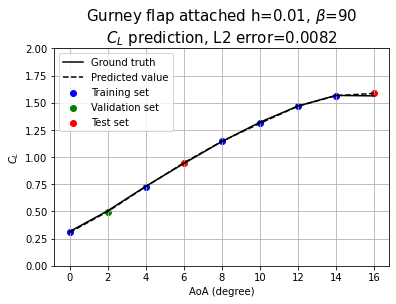

1/1 [==============================] - 0s 17ms/step
L2 error of Cl: 0.0051


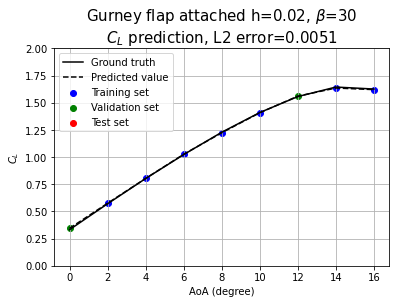

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0046


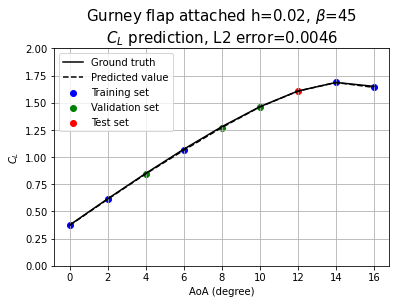

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0069


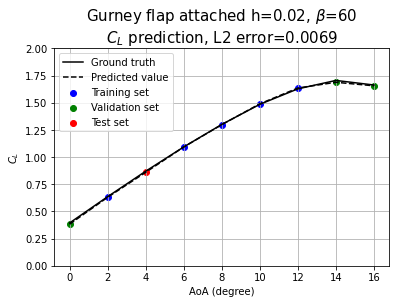

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0062


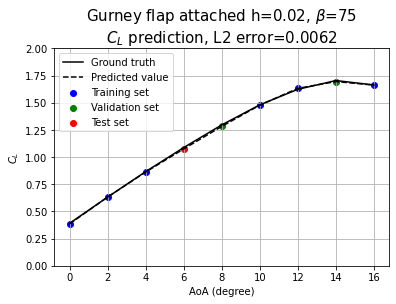

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0126


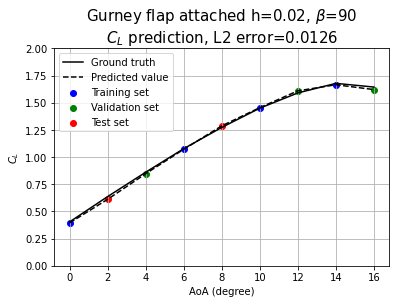

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0052


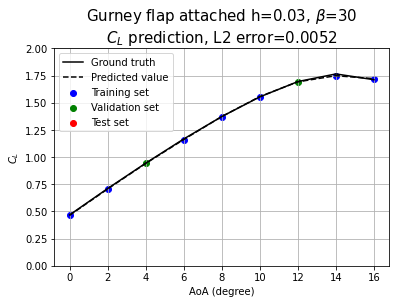

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0059


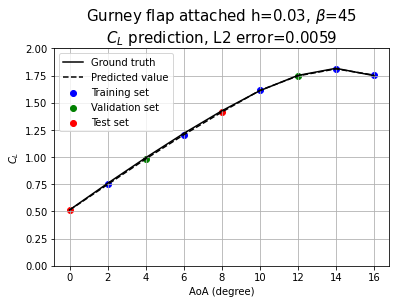

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0071


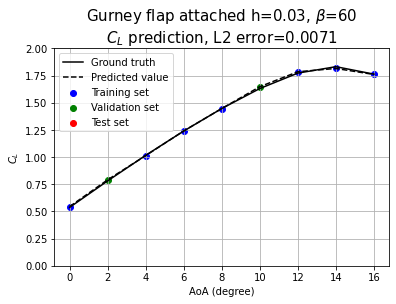

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0142


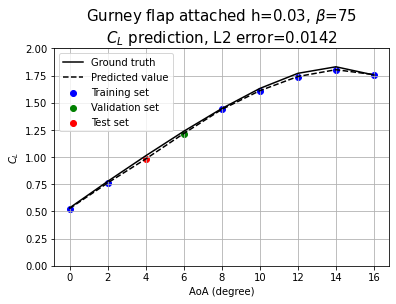

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0423


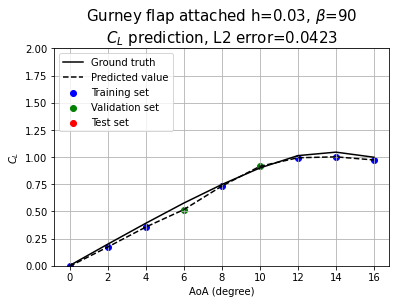

In [66]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    predictedValue = model.predict([x[n_alpha*i:n_alpha*(i+1),:], x_para[n_alpha*i:n_alpha*(i+1),:]])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cl = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    else:
        print('L2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1)]*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    CL = y[n_alpha*i:n_alpha*(i+1)]*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal.append(predicted[index])    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    iTest = np.array(iTest)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    iVal = np.array(iVal)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)*np.max(alpha)
    aVal = np.array(alpha_val)*np.max(alpha)
    aTest = np.array(alpha_test)*np.max(alpha)
    
    CL_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest)